# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import mlflow
from collections import defaultdict
from scipy.stats import zscore

# original library

import common as com
import pytorch_modeler as modeler
from pytorch_model import LSTM_AutoEncoder as Model
from pytorch_utils import filtered_load_model
import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
#with open("./config.yaml", 'rb') as f:
#    config = yaml.load(f)

log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_path = INPUT_ROOT + "/dev_data"
add_dev_path = INPUT_ROOT + "/add_dev_data"
# machine type
MACHINE_TYPE = config['IO_OPTION']['MACHINE_TYPE']
machine_types = os.listdir(dev_path)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
PKL_DIR = OUTPUT_ROOT + '/pkl'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(PKL_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/working/research/dcase2020/result/2D/LSTM_AEs/bidirectional_LSTM_AE_window_shift/config.yaml'

## make path list and train/valid split

In [7]:
############################################################################
# make path set and train/valid split
############################################################################
'''
train_paths[machine_type]['train' or 'valid'] = path
'''
dev_train_paths = {}
add_train_paths = {}
train_paths = {}

In [8]:
for machine_type in machine_types:
    # dev train
    dev_train_paths = ["{}/{}/train/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(dev_path, machine_type))]
    dev_train_paths = sorted(dev_train_paths)
    # add_dev train
    add_train_paths = ["{}/{}/train/".format(add_dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(add_dev_path, machine_type))]
    add_train_paths = sorted(add_train_paths)
    # valid
    dev_valid_paths = ["{}/{}/test/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/test".format(dev_path, machine_type))]
    dev_valid_paths = sorted(dev_valid_paths)
    
    train_paths[machine_type] = {}
    train_paths[machine_type]['train'] = dev_train_paths + add_train_paths
    train_paths[machine_type]['valid'] = dev_valid_paths

## training

In [9]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(train_paths, machine_type)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)         # debug
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    logger.info('TRAINING')
    # parameter setting
    net = Model(sample_rate=config['preprocessing']['sample_rate'],
                window_size=config['preprocessing']['window_size'],
                hop_size=config['preprocessing']['hop_size'],
                mel_bins=config['preprocessing']['mel_bins'],
                fmin=config['preprocessing']['fmin'],
                fmax=config['preprocessing']['fmax'],
                aug_window_size=config['fit']['aug_window_size'],
                aug_hop_size=config['fit']['aug_hop_size']
                )
    #pretrained_dict = torch.load(config['IO_OPTION']['PREMODEL_PATH'])
    #net = filtered_load_model(net, pretrained_dict)
    optimizer = optim.Adam(net.parameters(), lr=1e-2)
    criterion = nn.MSELoss()
    num_epochs = config['fit']['num_epochs']
    history = modeler.train_net(net, dataloaders_dict, criterion, optimizer, num_epochs, writer)
    # output
    model = history['model']
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    torch.save(model.state_dict(), model_out_path)
    logger.info('\n success:{0} \n'.format(machine_type) + \
                    'model_out_path ==> \n {0}'.format(model_out_path))
    #  close writer for tensorbord
    writer.close()
    #modeler.mlflow_log(history, config, machine_type, model_out_path, tb_log_dir)
    com.toc()
    return history

In [10]:
machine_types

['fan', 'pump', 'slider', 'ToyCar', 'ToyConveyor', 'valve']

2020-11-08 00:55:54,276 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2020-11-08 00:55:54,277 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-08 00:55:55,378 - 00_train.py - INFO - TRAINING


use: cuda:0


100%|██████████| 1803/1803 [00:27<00:00, 66.63it/s]


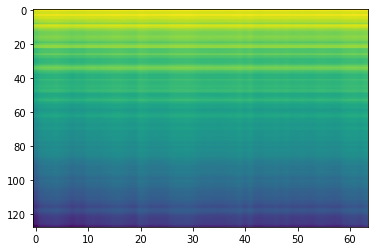

2020-11-08 00:57:43,896 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:122.278359, valid_AUC:0.502220, valid_pAUC:0.509875
100%|██████████| 1803/1803 [00:19<00:00, 94.21it/s] 
2020-11-08 00:58:22,526 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:17.007360, valid_AUC:0.505196, valid_pAUC:0.510316
100%|██████████| 1803/1803 [00:18<00:00, 95.77it/s] 
2020-11-08 00:59:01,657 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:16.638395, valid_AUC:0.502341, valid_pAUC:0.515728
100%|██████████| 1803/1803 [00:18<00:00, 98.66it/s] 
2020-11-08 00:59:40,414 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:16.505543, valid_AUC:0.508352, valid_pAUC:0.515240
100%|██████████| 1803/1803 [00:18<00:00, 98.61it/s] 
2020-11-08 01:00:19,894 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:16.332257, valid_AUC:0.499948, valid_pAUC:0.514415
100%|██████████| 1803/1803 [00:18<00:00, 97.82it/s]
2020-11-08 01:00:59,421 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:16.320356, valid_A

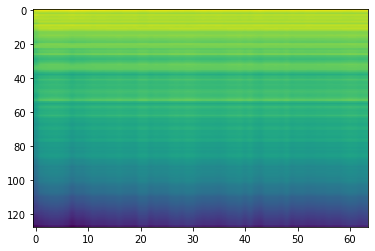

2020-11-08 01:03:37,767 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:14.594173, valid_AUC:0.499301, valid_pAUC:0.513195
100%|██████████| 1803/1803 [00:18<00:00, 99.31it/s] 
2020-11-08 01:04:16,343 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:14.270902, valid_AUC:0.500399, valid_pAUC:0.508675
100%|██████████| 1803/1803 [00:18<00:00, 98.70it/s] 
2020-11-08 01:04:55,613 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:14.037748, valid_AUC:0.503473, valid_pAUC:0.512145
100%|██████████| 1803/1803 [00:18<00:00, 99.97it/s] 
2020-11-08 01:05:34,698 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:13.934054, valid_AUC:0.502662, valid_pAUC:0.511892
100%|██████████| 1803/1803 [00:19<00:00, 94.80it/s]
2020-11-08 01:06:14,423 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:13.716331, valid_AUC:0.505324, valid_pAUC:0.511535
100%|██████████| 1803/1803 [00:19<00:00, 93.49it/s] 
2020-11-08 01:06:53,879 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:13.528851, va

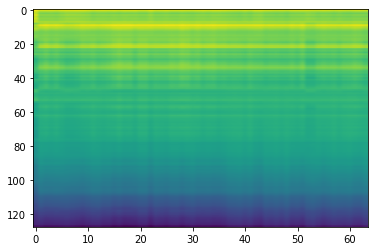

2020-11-08 01:10:14,274 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:13.115756, valid_AUC:0.510285, valid_pAUC:0.503836
100%|██████████| 1803/1803 [00:19<00:00, 94.68it/s] 
2020-11-08 01:10:53,668 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:13.196118, valid_AUC:0.522349, valid_pAUC:0.503723
100%|██████████| 1803/1803 [00:19<00:00, 94.58it/s] 
2020-11-08 01:11:32,574 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:13.050950, valid_AUC:0.533368, valid_pAUC:0.510513
100%|██████████| 1803/1803 [00:20<00:00, 89.78it/s]
2020-11-08 01:12:12,467 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:12.970873, valid_AUC:0.524825, valid_pAUC:0.504408
100%|██████████| 1803/1803 [00:18<00:00, 95.01it/s] 
2020-11-08 01:12:51,491 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:12.910784, valid_AUC:0.521055, valid_pAUC:0.505458
100%|██████████| 1803/1803 [00:18<00:00, 98.79it/s] 
2020-11-08 01:13:30,082 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:13.020491, va

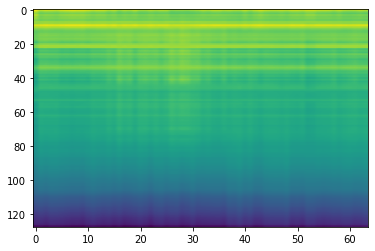

2020-11-08 01:17:07,646 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:12.652563, valid_AUC:0.540567, valid_pAUC:0.506058
100%|██████████| 1803/1803 [00:22<00:00, 78.51it/s]
2020-11-08 01:17:54,882 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:12.596222, valid_AUC:0.541964, valid_pAUC:0.503573
100%|██████████| 1803/1803 [00:22<00:00, 78.56it/s]
2020-11-08 01:18:43,310 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:12.602822, valid_AUC:0.542999, valid_pAUC:0.503583
100%|██████████| 1803/1803 [00:23<00:00, 75.52it/s]
2020-11-08 01:19:32,925 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:12.462709, valid_AUC:0.542094, valid_pAUC:0.504727
100%|██████████| 1803/1803 [00:24<00:00, 74.99it/s]
2020-11-08 01:20:21,603 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:12.425681, valid_AUC:0.539658, valid_pAUC:0.505299
100%|██████████| 1803/1803 [00:23<00:00, 78.13it/s]
2020-11-08 01:21:10,570 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:12.431732, valid_

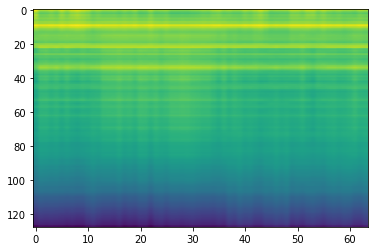

2020-11-08 01:25:12,528 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:11.968338, valid_AUC:0.537507, valid_pAUC:0.505880
100%|██████████| 1803/1803 [00:22<00:00, 80.42it/s]
2020-11-08 01:25:59,821 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:11.803059, valid_AUC:0.531033, valid_pAUC:0.503826
100%|██████████| 1803/1803 [00:22<00:00, 79.67it/s]
2020-11-08 01:26:47,912 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:11.911977, valid_AUC:0.527393, valid_pAUC:0.503282
100%|██████████| 1803/1803 [00:23<00:00, 77.92it/s]
2020-11-08 01:27:35,651 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:11.815549, valid_AUC:0.528877, valid_pAUC:0.501735
100%|██████████| 1803/1803 [00:22<00:00, 78.67it/s]
2020-11-08 01:28:22,151 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:11.763330, valid_AUC:0.535804, valid_pAUC:0.501529
100%|██████████| 1803/1803 [00:22<00:00, 79.92it/s]
2020-11-08 01:29:08,289 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:11.646867, valid_

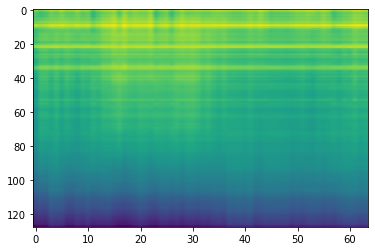

2020-11-08 01:32:34,290 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:11.468698, valid_AUC:0.537140, valid_pAUC:0.503151
100%|██████████| 1803/1803 [00:12<00:00, 146.51it/s]
2020-11-08 01:33:03,345 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:11.359357, valid_AUC:0.538371, valid_pAUC:0.501848
100%|██████████| 1803/1803 [00:12<00:00, 148.26it/s]
2020-11-08 01:33:32,709 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:11.332799, valid_AUC:0.529047, valid_pAUC:0.504652
100%|██████████| 1803/1803 [00:14<00:00, 126.85it/s]
2020-11-08 01:34:03,766 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:11.311370, valid_AUC:0.541041, valid_pAUC:0.507343
100%|██████████| 1803/1803 [00:15<00:00, 117.29it/s]
2020-11-08 01:34:35,428 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:11.293910, valid_AUC:0.546221, valid_pAUC:0.505102
100%|██████████| 1803/1803 [00:13<00:00, 133.84it/s]
2020-11-08 01:35:05,104 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:11.263530, v

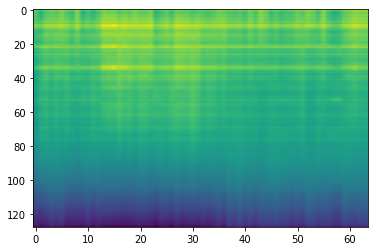

2020-11-08 01:37:35,836 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:11.108066, valid_AUC:0.544963, valid_pAUC:0.509153
100%|██████████| 1803/1803 [00:11<00:00, 158.25it/s]
2020-11-08 01:38:04,513 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:11.081383, valid_AUC:0.544211, valid_pAUC:0.507259
100%|██████████| 1803/1803 [00:13<00:00, 135.76it/s]
2020-11-08 01:38:34,840 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:11.067293, valid_AUC:0.540185, valid_pAUC:0.509866
100%|██████████| 1803/1803 [00:15<00:00, 118.90it/s]
2020-11-08 01:39:06,421 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:10.952223, valid_AUC:0.549865, valid_pAUC:0.509144
100%|██████████| 1803/1803 [00:14<00:00, 122.86it/s]
2020-11-08 01:39:37,125 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:11.002029, valid_AUC:0.543649, valid_pAUC:0.511310
100%|██████████| 1803/1803 [00:12<00:00, 142.95it/s]
2020-11-08 01:40:06,387 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:11.039325, v

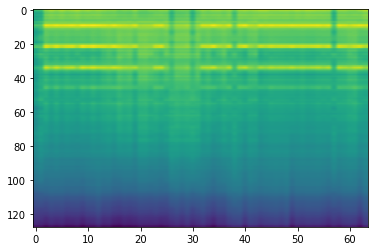

2020-11-08 01:42:37,057 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:10.959850, valid_AUC:0.547316, valid_pAUC:0.510935
100%|██████████| 1803/1803 [00:12<00:00, 146.66it/s]
2020-11-08 01:43:06,458 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:10.963443, valid_AUC:0.545734, valid_pAUC:0.510504
100%|██████████| 1803/1803 [00:14<00:00, 123.22it/s]
2020-11-08 01:43:37,844 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:10.878695, valid_AUC:0.548906, valid_pAUC:0.511338
100%|██████████| 1803/1803 [00:15<00:00, 117.80it/s]
2020-11-08 01:44:09,153 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:10.907620, valid_AUC:0.554728, valid_pAUC:0.510804
100%|██████████| 1803/1803 [00:13<00:00, 131.48it/s]
2020-11-08 01:44:39,020 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:10.825539, valid_AUC:0.552040, valid_pAUC:0.513843
100%|██████████| 1803/1803 [00:11<00:00, 156.75it/s]
2020-11-08 01:45:07,290 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:10.812029, v

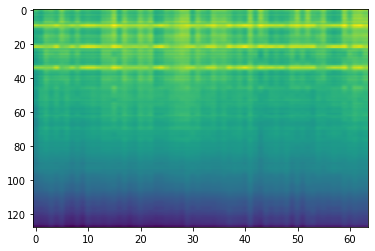

2020-11-08 01:47:37,356 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:10.713486, valid_AUC:0.548760, valid_pAUC:0.511460
100%|██████████| 1803/1803 [00:12<00:00, 145.52it/s]
2020-11-08 01:48:06,815 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:10.821768, valid_AUC:0.542751, valid_pAUC:0.511986
100%|██████████| 1803/1803 [00:14<00:00, 123.09it/s]
2020-11-08 01:48:38,123 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:10.634276, valid_AUC:0.557092, valid_pAUC:0.511489
100%|██████████| 1803/1803 [00:15<00:00, 118.18it/s]
2020-11-08 01:49:09,397 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:10.622083, valid_AUC:0.548619, valid_pAUC:0.511582
100%|██████████| 1803/1803 [00:13<00:00, 137.56it/s]
2020-11-08 01:49:39,049 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:10.496372, valid_AUC:0.550397, valid_pAUC:0.512164
100%|██████████| 1803/1803 [00:11<00:00, 156.89it/s]
2020-11-08 01:50:07,605 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:10.512402, v

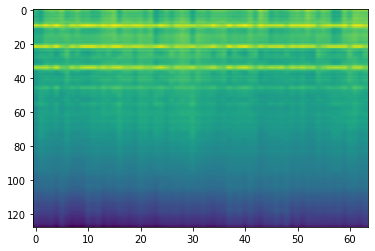

2020-11-08 01:52:38,209 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:10.413422, valid_AUC:0.555804, valid_pAUC:0.510147
100%|██████████| 1803/1803 [00:13<00:00, 133.25it/s]
2020-11-08 01:53:08,951 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:10.460813, valid_AUC:0.549563, valid_pAUC:0.510344
100%|██████████| 1803/1803 [00:15<00:00, 117.79it/s]
2020-11-08 01:53:40,737 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:10.396550, valid_AUC:0.554241, valid_pAUC:0.510813
100%|██████████| 1803/1803 [00:15<00:00, 113.28it/s]
2020-11-08 01:54:12,811 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:10.300490, valid_AUC:0.562370, valid_pAUC:0.511704
100%|██████████| 1803/1803 [00:13<00:00, 129.46it/s]
2020-11-08 01:54:44,634 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:10.329110, valid_AUC:0.561919, valid_pAUC:0.512905
100%|██████████| 1803/1803 [00:13<00:00, 136.08it/s]
2020-11-08 01:55:16,879 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:10.307987, v

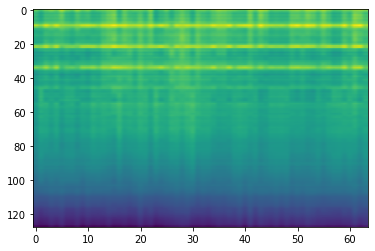

2020-11-08 01:57:59,612 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:10.141753, valid_AUC:0.555271, valid_pAUC:0.511498
2020-11-08 01:57:59,680 - 00_train.py - INFO - 
 success:fan 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AEs/bidirectional_LSTM_AE_window_shift/models/fan_model.pth


elapsed time: 3725.407629013 [sec]


2020-11-08 01:58:00,437 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2020-11-08 01:58:00,438 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-08 01:58:00,445 - 00_train.py - INFO - TRAINING
  0%|          | 0/91 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 832/832 [00:10<00:00, 79.16it/s]


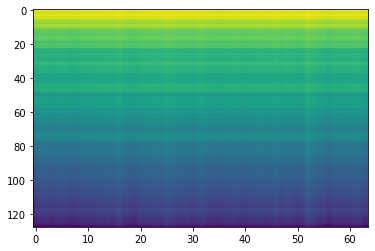

2020-11-08 01:59:21,095 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:129.934454, valid_AUC:0.548200, valid_pAUC:0.489979
100%|██████████| 832/832 [00:06<00:00, 121.11it/s]
2020-11-08 01:59:43,430 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:18.400077, valid_AUC:0.647373, valid_pAUC:0.524702
100%|██████████| 832/832 [00:07<00:00, 105.19it/s]
2020-11-08 02:00:06,238 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:17.964331, valid_AUC:0.676262, valid_pAUC:0.551870
100%|██████████| 832/832 [00:07<00:00, 106.47it/s]
2020-11-08 02:00:28,188 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:17.556952, valid_AUC:0.678466, valid_pAUC:0.556043
100%|██████████| 832/832 [00:06<00:00, 137.07it/s]
2020-11-08 02:00:49,148 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:17.525748, valid_AUC:0.694120, valid_pAUC:0.561556
100%|██████████| 832/832 [00:05<00:00, 151.04it/s]
2020-11-08 02:01:10,335 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:17.725819, valid_AUC:0.6827

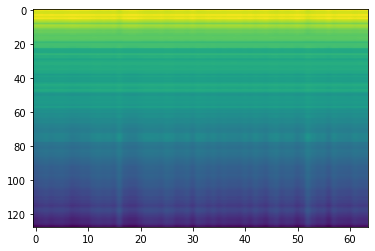

2020-11-08 02:02:38,147 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:17.463067, valid_AUC:0.654566, valid_pAUC:0.539656
100%|██████████| 832/832 [00:05<00:00, 158.36it/s]
2020-11-08 02:02:58,734 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:17.385282, valid_AUC:0.648958, valid_pAUC:0.537677
100%|██████████| 832/832 [00:05<00:00, 160.98it/s]
2020-11-08 02:03:19,316 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:17.356720, valid_AUC:0.663866, valid_pAUC:0.542885
100%|██████████| 832/832 [00:06<00:00, 125.60it/s]
2020-11-08 02:03:40,759 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:17.418255, valid_AUC:0.668843, valid_pAUC:0.548824
100%|██████████| 832/832 [00:08<00:00, 102.36it/s]
2020-11-08 02:04:03,248 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:17.542695, valid_AUC:0.673675, valid_pAUC:0.547971
100%|██████████| 832/832 [00:07<00:00, 117.71it/s]
2020-11-08 02:04:24,405 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:17.353595, valid_AUC:0

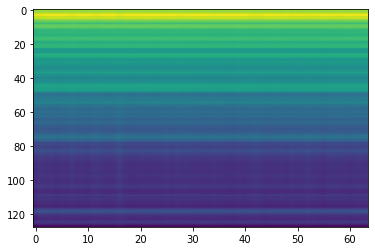

2020-11-08 02:06:15,352 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:16.660579, valid_AUC:0.688218, valid_pAUC:0.606268
100%|██████████| 832/832 [00:05<00:00, 148.82it/s]
2020-11-08 02:06:36,002 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:16.680853, valid_AUC:0.674890, valid_pAUC:0.581841
100%|██████████| 832/832 [00:06<00:00, 132.63it/s]
2020-11-08 02:06:57,545 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:16.431105, valid_AUC:0.686609, valid_pAUC:0.590491
100%|██████████| 832/832 [00:08<00:00, 101.88it/s]
2020-11-08 02:07:20,465 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:16.211340, valid_AUC:0.676927, valid_pAUC:0.582206
100%|██████████| 832/832 [00:06<00:00, 118.86it/s]
2020-11-08 02:07:42,074 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:16.242559, valid_AUC:0.690249, valid_pAUC:0.596613
100%|██████████| 832/832 [00:05<00:00, 154.43it/s]
2020-11-08 02:08:02,766 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:16.131755, valid_AUC:0

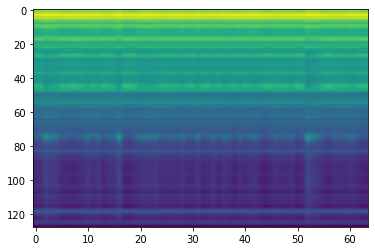

2020-11-08 02:09:52,630 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:15.979480, valid_AUC:0.670903, valid_pAUC:0.591892
100%|██████████| 832/832 [00:07<00:00, 108.28it/s]
2020-11-08 02:10:15,290 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:16.017868, valid_AUC:0.584219, valid_pAUC:0.499239
100%|██████████| 832/832 [00:05<00:00, 142.22it/s]
2020-11-08 02:10:36,193 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:15.923487, valid_AUC:0.692280, valid_pAUC:0.605080
100%|██████████| 832/832 [00:06<00:00, 132.78it/s]
2020-11-08 02:10:57,645 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:15.477114, valid_AUC:0.669421, valid_pAUC:0.573343
100%|██████████| 832/832 [00:07<00:00, 104.79it/s]
2020-11-08 02:11:20,255 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:15.207821, valid_AUC:0.678356, valid_pAUC:0.583364
100%|██████████| 832/832 [00:07<00:00, 114.41it/s]
2020-11-08 02:11:42,385 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:15.175891, valid_AUC:0

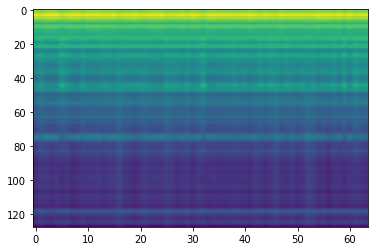

2020-11-08 02:13:30,600 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:15.023836, valid_AUC:0.641707, valid_pAUC:0.541423
100%|██████████| 832/832 [00:07<00:00, 114.51it/s]
2020-11-08 02:13:52,873 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:14.864856, valid_AUC:0.684462, valid_pAUC:0.584399
100%|██████████| 832/832 [00:08<00:00, 102.35it/s]
2020-11-08 02:14:15,782 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:14.727730, valid_AUC:0.670706, valid_pAUC:0.562074
100%|██████████| 832/832 [00:06<00:00, 132.66it/s]
2020-11-08 02:14:36,884 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:14.710706, valid_AUC:0.670509, valid_pAUC:0.569658
100%|██████████| 832/832 [00:05<00:00, 146.18it/s]
2020-11-08 02:14:57,779 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:14.845248, valid_AUC:0.669115, valid_pAUC:0.555038
100%|██████████| 832/832 [00:07<00:00, 112.41it/s]
2020-11-08 02:15:20,216 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:14.736385, valid_AUC:0

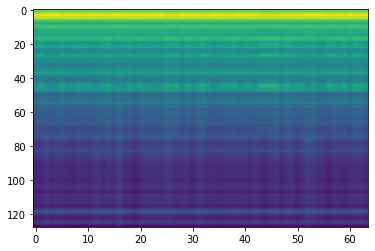

2020-11-08 02:17:10,519 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:14.445037, valid_AUC:0.679502, valid_pAUC:0.578673
100%|██████████| 832/832 [00:05<00:00, 147.17it/s]
2020-11-08 02:17:31,066 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:14.314160, valid_AUC:0.684988, valid_pAUC:0.568957
100%|██████████| 832/832 [00:06<00:00, 119.62it/s]
2020-11-08 02:17:53,276 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:14.419362, valid_AUC:0.689809, valid_pAUC:0.579069
100%|██████████| 832/832 [00:08<00:00, 103.88it/s]
2020-11-08 02:18:16,306 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:14.191802, valid_AUC:0.674624, valid_pAUC:0.561495
100%|██████████| 832/832 [00:06<00:00, 124.87it/s]
2020-11-08 02:18:37,840 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:14.118004, valid_AUC:0.693218, valid_pAUC:0.605446
100%|██████████| 832/832 [00:05<00:00, 151.70it/s]
2020-11-08 02:18:58,595 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:14.222027, valid_AUC:0

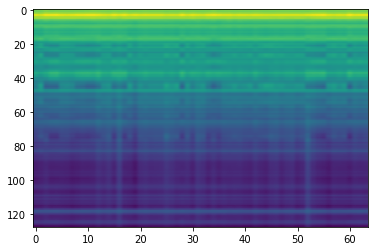

2020-11-08 02:20:49,220 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:14.027094, valid_AUC:0.684722, valid_pAUC:0.568378
100%|██████████| 832/832 [00:07<00:00, 109.08it/s]
2020-11-08 02:21:11,484 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:14.034230, valid_AUC:0.668223, valid_pAUC:0.564937
100%|██████████| 832/832 [00:05<00:00, 142.70it/s]
2020-11-08 02:21:32,262 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:14.040860, valid_AUC:0.680353, valid_pAUC:0.559667
100%|██████████| 832/832 [00:06<00:00, 128.55it/s]
2020-11-08 02:21:53,953 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:13.865242, valid_AUC:0.693536, valid_pAUC:0.577303
100%|██████████| 832/832 [00:07<00:00, 105.04it/s]
2020-11-08 02:22:16,690 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:13.993109, valid_AUC:0.685949, valid_pAUC:0.572094
100%|██████████| 832/832 [00:07<00:00, 114.58it/s]
2020-11-08 02:22:38,772 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:14.005358, valid_AUC:0

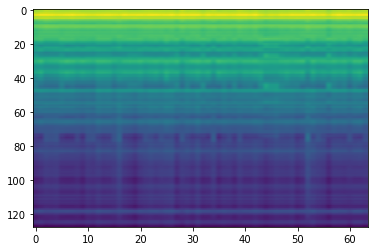

2020-11-08 02:24:26,193 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:13.768986, valid_AUC:0.647164, valid_pAUC:0.555891
100%|██████████| 832/832 [00:06<00:00, 122.73it/s]
2020-11-08 02:24:48,292 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:14.019891, valid_AUC:0.676968, valid_pAUC:0.574348
100%|██████████| 832/832 [00:07<00:00, 105.13it/s]
2020-11-08 02:25:10,997 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:13.703080, valid_AUC:0.684740, valid_pAUC:0.583638
100%|██████████| 832/832 [00:06<00:00, 119.93it/s]
2020-11-08 02:25:32,617 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:13.621225, valid_AUC:0.691111, valid_pAUC:0.589486
100%|██████████| 832/832 [00:05<00:00, 147.40it/s]
2020-11-08 02:25:53,197 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:13.542177, valid_AUC:0.682622, valid_pAUC:0.575079
100%|██████████| 832/832 [00:06<00:00, 128.47it/s]
2020-11-08 02:26:14,938 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:13.602380, valid_AUC:0

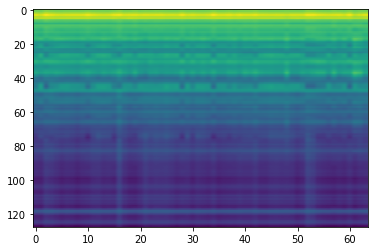

2020-11-08 02:28:04,825 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:13.193410, valid_AUC:0.693542, valid_pAUC:0.597923
100%|██████████| 832/832 [00:06<00:00, 124.32it/s]
2020-11-08 02:28:26,470 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:13.350480, valid_AUC:0.690914, valid_pAUC:0.595913
100%|██████████| 832/832 [00:05<00:00, 153.80it/s]
2020-11-08 02:28:47,150 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:13.253965, valid_AUC:0.690208, valid_pAUC:0.590430
100%|██████████| 832/832 [00:07<00:00, 116.58it/s]
2020-11-08 02:29:09,542 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:13.141929, valid_AUC:0.701921, valid_pAUC:0.603923
100%|██████████| 832/832 [00:07<00:00, 104.93it/s]
2020-11-08 02:29:32,396 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:13.182774, valid_AUC:0.698918, valid_pAUC:0.601182
100%|██████████| 832/832 [00:06<00:00, 129.07it/s]
2020-11-08 02:29:53,520 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:13.021566, valid_AUC:0

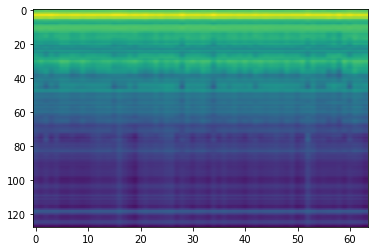

2020-11-08 02:31:42,283 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:12.620960, valid_AUC:0.680663, valid_pAUC:0.579861
100%|██████████| 832/832 [00:07<00:00, 105.24it/s]
2020-11-08 02:32:05,247 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:12.631137, valid_AUC:0.682963, valid_pAUC:0.572978
100%|██████████| 832/832 [00:07<00:00, 113.30it/s]
2020-11-08 02:32:27,332 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:12.648523, valid_AUC:0.689618, valid_pAUC:0.598532
100%|██████████| 832/832 [00:05<00:00, 142.38it/s]
2020-11-08 02:32:48,359 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:12.572715, valid_AUC:0.689225, valid_pAUC:0.577638
100%|██████████| 832/832 [00:06<00:00, 124.82it/s]
2020-11-08 02:33:10,484 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:12.394929, valid_AUC:0.700613, valid_pAUC:0.597953
100%|██████████| 832/832 [00:09<00:00, 89.21it/s]
2020-11-08 02:33:58,917 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:12.557092, valid_AUC:0.

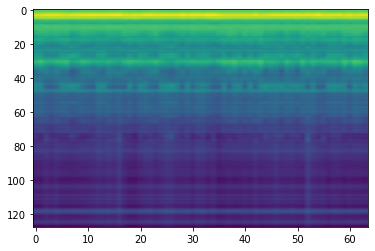

2020-11-08 02:35:53,577 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:12.194147, valid_AUC:0.692228, valid_pAUC:0.574592
2020-11-08 02:35:53,630 - 00_train.py - INFO - 
 success:pump 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AEs/bidirectional_LSTM_AE_window_shift/models/pump_model.pth


elapsed time: 2273.194062233 [sec]


2020-11-08 02:35:54,172 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2020-11-08 02:35:54,173 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-08 02:35:54,174 - 00_train.py - INFO - TRAINING
  1%|          | 1/81 [00:00<00:11,  6.70it/s]

use: cuda:0


100%|██████████| 1246/1246 [00:07<00:00, 158.08it/s]


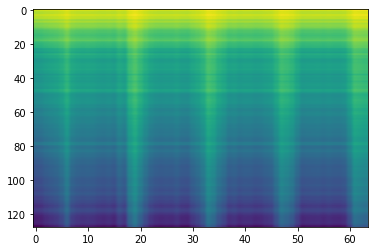

2020-11-08 02:36:16,086 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:161.625299, valid_AUC:0.584719, valid_pAUC:0.504386
100%|██████████| 1246/1246 [00:09<00:00, 131.55it/s]
2020-11-08 02:36:39,094 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:20.240786, valid_AUC:0.560310, valid_pAUC:0.499020
100%|██████████| 1246/1246 [00:10<00:00, 114.04it/s]
2020-11-08 02:37:02,989 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:19.652932, valid_AUC:0.510632, valid_pAUC:0.486018
100%|██████████| 1246/1246 [00:10<00:00, 120.23it/s]
2020-11-08 02:37:25,891 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:19.401124, valid_AUC:0.542361, valid_pAUC:0.488071
100%|██████████| 1246/1246 [00:08<00:00, 141.24it/s]
2020-11-08 02:37:47,794 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:19.212549, valid_AUC:0.563410, valid_pAUC:0.490855
100%|██████████| 1246/1246 [00:08<00:00, 149.69it/s]
2020-11-08 02:38:09,500 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:19.080374, valid_

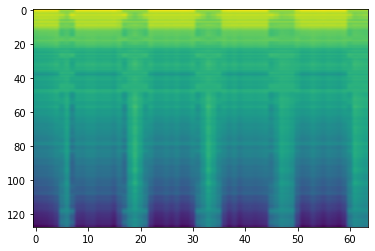

2020-11-08 02:39:40,963 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:17.566589, valid_AUC:0.592695, valid_pAUC:0.507357
100%|██████████| 1246/1246 [00:08<00:00, 144.25it/s]
2020-11-08 02:40:03,284 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:17.221433, valid_AUC:0.531413, valid_pAUC:0.497869
100%|██████████| 1246/1246 [00:10<00:00, 122.69it/s]
2020-11-08 02:40:26,562 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:17.053899, valid_AUC:0.613694, valid_pAUC:0.515320
100%|██████████| 1246/1246 [00:10<00:00, 114.66it/s]
2020-11-08 02:40:50,232 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:16.604158, valid_AUC:0.576368, valid_pAUC:0.504230
100%|██████████| 1246/1246 [00:09<00:00, 134.27it/s]
2020-11-08 02:41:12,582 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:16.319682, valid_AUC:0.546424, valid_pAUC:0.496936
100%|██████████| 1246/1246 [00:07<00:00, 159.26it/s]
2020-11-08 02:41:33,814 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:16.062093, v

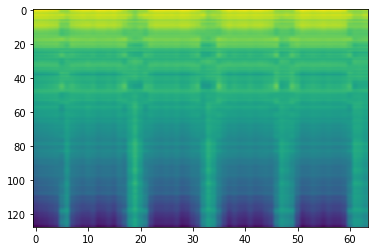

2020-11-08 02:43:28,015 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:15.821862, valid_AUC:0.593712, valid_pAUC:0.505972
100%|██████████| 1246/1246 [00:10<00:00, 123.92it/s]
2020-11-08 02:43:51,491 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:15.886994, valid_AUC:0.613658, valid_pAUC:0.509254
100%|██████████| 1246/1246 [00:11<00:00, 113.26it/s]
2020-11-08 02:44:15,333 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:15.595827, valid_AUC:0.628044, valid_pAUC:0.514495
100%|██████████| 1246/1246 [00:09<00:00, 128.55it/s]
2020-11-08 02:44:38,218 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:15.615931, valid_AUC:0.631427, valid_pAUC:0.515740
100%|██████████| 1246/1246 [00:08<00:00, 154.51it/s]
2020-11-08 02:44:59,725 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:15.497608, valid_AUC:0.633496, valid_pAUC:0.516517
100%|██████████| 1246/1246 [00:09<00:00, 134.26it/s]
2020-11-08 02:45:22,658 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:15.230540, v

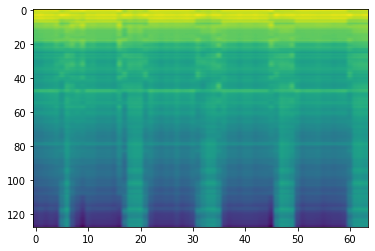

2020-11-08 02:47:17,681 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:14.894910, valid_AUC:0.620520, valid_pAUC:0.514076
100%|██████████| 1246/1246 [00:10<00:00, 113.57it/s]
2020-11-08 02:47:41,369 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:14.772766, valid_AUC:0.641708, valid_pAUC:0.519970
100%|██████████| 1246/1246 [00:09<00:00, 136.19it/s]
2020-11-08 02:48:03,606 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:14.747190, valid_AUC:0.633153, valid_pAUC:0.515258
100%|██████████| 1246/1246 [00:07<00:00, 157.36it/s]
2020-11-08 02:48:25,125 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:14.731270, valid_AUC:0.642550, valid_pAUC:0.519021
100%|██████████| 1246/1246 [00:09<00:00, 132.20it/s]
2020-11-08 02:48:48,380 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:14.607999, valid_AUC:0.639441, valid_pAUC:0.518881
100%|██████████| 1246/1246 [00:11<00:00, 111.88it/s]
2020-11-08 02:49:12,470 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:14.359751, v

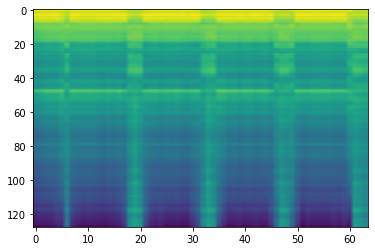

2020-11-08 02:51:06,400 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:13.915815, valid_AUC:0.649128, valid_pAUC:0.520172
100%|██████████| 1246/1246 [00:09<00:00, 131.81it/s]
2020-11-08 02:51:28,970 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:13.689832, valid_AUC:0.649022, valid_pAUC:0.521650
100%|██████████| 1246/1246 [00:08<00:00, 152.74it/s]
2020-11-08 02:51:50,680 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:13.615698, valid_AUC:0.653118, valid_pAUC:0.522956
100%|██████████| 1246/1246 [00:09<00:00, 133.67it/s]
2020-11-08 02:52:13,511 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:13.459966, valid_AUC:0.657657, valid_pAUC:0.517373
100%|██████████| 1246/1246 [00:11<00:00, 113.11it/s]
2020-11-08 02:52:37,520 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:13.194179, valid_AUC:0.660346, valid_pAUC:0.520623
100%|██████████| 1246/1246 [00:10<00:00, 122.67it/s]
2020-11-08 02:53:00,504 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:13.420128, v

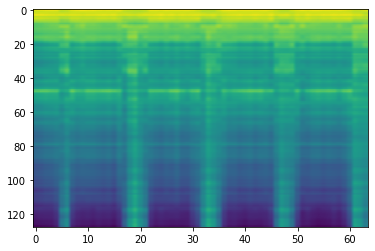

2020-11-08 02:54:54,254 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:12.791624, valid_AUC:0.643227, valid_pAUC:0.509674
100%|██████████| 1246/1246 [00:08<00:00, 155.13it/s]
2020-11-08 02:55:15,954 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:12.845209, valid_AUC:0.678286, valid_pAUC:0.526876
100%|██████████| 1246/1246 [00:09<00:00, 132.46it/s]
2020-11-08 02:55:38,877 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:12.676710, valid_AUC:0.695018, valid_pAUC:0.526238
100%|██████████| 1246/1246 [00:10<00:00, 114.79it/s]
2020-11-08 02:56:02,742 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:12.661506, valid_AUC:0.681348, valid_pAUC:0.519255
100%|██████████| 1246/1246 [00:10<00:00, 123.09it/s]
2020-11-08 02:56:25,654 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:12.558341, valid_AUC:0.689220, valid_pAUC:0.525911
100%|██████████| 1246/1246 [00:08<00:00, 148.07it/s]
2020-11-08 02:56:47,572 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:12.567949, v

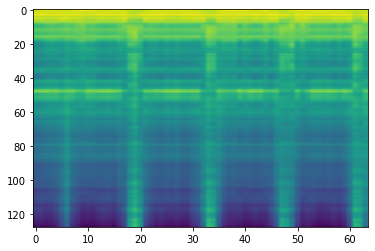

2020-11-08 02:58:41,129 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:12.338974, valid_AUC:0.686073, valid_pAUC:0.527684
100%|██████████| 1246/1246 [00:09<00:00, 131.51it/s]
2020-11-08 02:59:04,201 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:12.391409, valid_AUC:0.702580, valid_pAUC:0.537312
100%|██████████| 1246/1246 [00:10<00:00, 115.78it/s]
2020-11-08 02:59:28,054 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:12.391608, valid_AUC:0.665854, valid_pAUC:0.525336
100%|██████████| 1246/1246 [00:10<00:00, 123.35it/s]
2020-11-08 02:59:51,002 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:12.231215, valid_AUC:0.691637, valid_pAUC:0.534388
100%|██████████| 1246/1246 [00:08<00:00, 144.80it/s]
2020-11-08 03:00:13,005 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:12.205213, valid_AUC:0.685372, valid_pAUC:0.529862
100%|██████████| 1246/1246 [00:08<00:00, 145.86it/s]
2020-11-08 03:00:35,051 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:12.168889, v

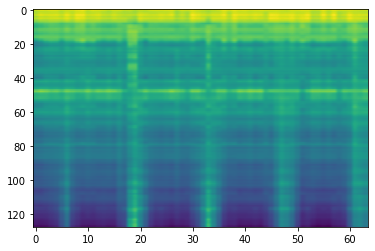

2020-11-08 03:02:28,569 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:12.086710, valid_AUC:0.681306, valid_pAUC:0.538680
100%|██████████| 1246/1246 [00:09<00:00, 125.50it/s]
2020-11-08 03:02:51,716 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:12.026527, valid_AUC:0.698345, valid_pAUC:0.543673
100%|██████████| 1246/1246 [00:11<00:00, 111.23it/s]
2020-11-08 03:03:15,845 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:11.991321, valid_AUC:0.691185, valid_pAUC:0.540796
100%|██████████| 1246/1246 [00:09<00:00, 134.37it/s]
2020-11-08 03:03:38,228 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:11.883248, valid_AUC:0.690694, valid_pAUC:0.540671
100%|██████████| 1246/1246 [00:07<00:00, 157.53it/s]
2020-11-08 03:03:59,834 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:11.866152, valid_AUC:0.685449, valid_pAUC:0.546193
100%|██████████| 1246/1246 [00:09<00:00, 136.99it/s]
2020-11-08 03:04:22,612 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:11.840880, v

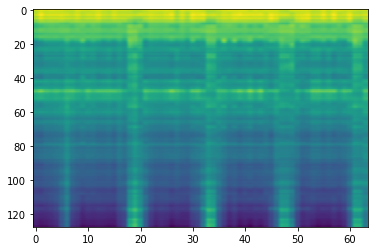

2020-11-08 03:07:03,427 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:11.775488, valid_AUC:0.691451, valid_pAUC:0.546364
100%|██████████| 1246/1246 [00:14<00:00, 86.45it/s]
2020-11-08 03:07:33,426 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:11.565214, valid_AUC:0.694226, valid_pAUC:0.548106
100%|██████████| 1246/1246 [00:08<00:00, 146.79it/s]
2020-11-08 03:07:56,633 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:11.517466, valid_AUC:0.707663, valid_pAUC:0.550159
100%|██████████| 1246/1246 [00:07<00:00, 161.41it/s]
2020-11-08 03:08:18,118 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:11.460242, valid_AUC:0.702784, valid_pAUC:0.548743
100%|██████████| 1246/1246 [00:10<00:00, 115.41it/s]
2020-11-08 03:08:42,114 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:11.413547, valid_AUC:0.701977, valid_pAUC:0.549956
100%|██████████| 1246/1246 [00:10<00:00, 116.36it/s]
2020-11-08 03:09:05,322 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:11.381641, va

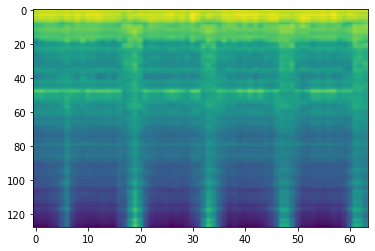

2020-11-08 03:10:56,269 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:11.177227, valid_AUC:0.715431, valid_pAUC:0.558215
100%|██████████| 1246/1246 [00:09<00:00, 125.88it/s]
2020-11-08 03:11:19,630 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:11.185971, valid_AUC:0.711055, valid_pAUC:0.560470
100%|██████████| 1246/1246 [00:11<00:00, 110.25it/s]
2020-11-08 03:11:43,322 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:11.342241, valid_AUC:0.699616, valid_pAUC:0.556302
100%|██████████| 1246/1246 [00:07<00:00, 157.81it/s]
2020-11-08 03:12:04,091 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:11.129914, valid_AUC:0.716472, valid_pAUC:0.556675
100%|██████████| 1246/1246 [00:07<00:00, 159.02it/s]
2020-11-08 03:12:25,881 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:11.168582, valid_AUC:0.694902, valid_pAUC:0.545975
100%|██████████| 1246/1246 [00:10<00:00, 113.74it/s]
2020-11-08 03:12:50,084 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:11.159775, v

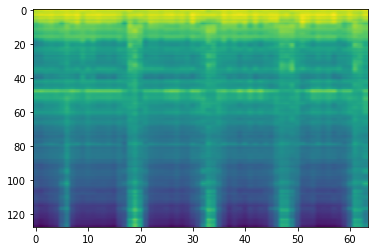

2020-11-08 03:14:42,082 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:10.998878, valid_AUC:0.712222, valid_pAUC:0.564016
2020-11-08 03:14:42,153 - 00_train.py - INFO - 
 success:slider 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AEs/bidirectional_LSTM_AE_window_shift/models/slider_model.pth


elapsed time: 2327.982030392 [sec]


2020-11-08 03:14:42,829 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2020-11-08 03:14:42,830 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-08 03:14:42,834 - 00_train.py - INFO - TRAINING
  1%|          | 1/110 [00:00<00:17,  6.24it/s]

use: cuda:0


100%|██████████| 2407/2407 [00:18<00:00, 129.64it/s]


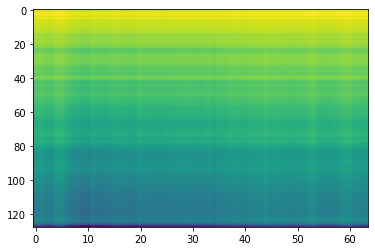

2020-11-08 03:15:20,602 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:107.447367, valid_AUC:0.642549, valid_pAUC:0.537837
100%|██████████| 2407/2407 [00:19<00:00, 121.20it/s]
2020-11-08 03:15:58,147 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:15.395126, valid_AUC:0.646208, valid_pAUC:0.533331
100%|██████████| 2407/2407 [00:18<00:00, 128.26it/s]
2020-11-08 03:16:34,714 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:15.309663, valid_AUC:0.644472, valid_pAUC:0.529138
100%|██████████| 2407/2407 [00:16<00:00, 144.76it/s]
2020-11-08 03:17:09,911 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:15.162462, valid_AUC:0.649013, valid_pAUC:0.528869
100%|██████████| 2407/2407 [00:15<00:00, 153.28it/s]
2020-11-08 03:17:44,554 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:15.153685, valid_AUC:0.651471, valid_pAUC:0.529269
100%|██████████| 2407/2407 [00:17<00:00, 136.18it/s]
2020-11-08 03:18:21,170 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:15.223950, valid_

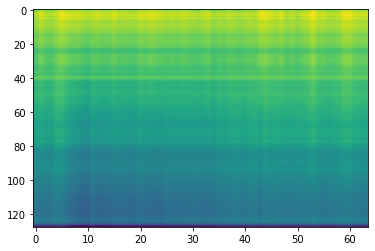

2020-11-08 03:20:45,685 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:12.530751, valid_AUC:0.734164, valid_pAUC:0.594582
100%|██████████| 2407/2407 [00:17<00:00, 141.46it/s]
2020-11-08 03:21:21,681 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:12.496154, valid_AUC:0.730618, valid_pAUC:0.574845
100%|██████████| 2407/2407 [00:19<00:00, 122.93it/s]
2020-11-08 03:21:59,436 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:12.426545, valid_AUC:0.741485, valid_pAUC:0.573344
100%|██████████| 2407/2407 [00:19<00:00, 123.28it/s]
2020-11-08 03:22:36,296 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:12.316709, valid_AUC:0.720670, valid_pAUC:0.590237
100%|██████████| 2407/2407 [00:18<00:00, 133.64it/s]
2020-11-08 03:23:12,168 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:12.418846, valid_AUC:0.697033, valid_pAUC:0.573415
100%|██████████| 2407/2407 [00:15<00:00, 150.68it/s]
2020-11-08 03:23:46,723 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:12.176252, v

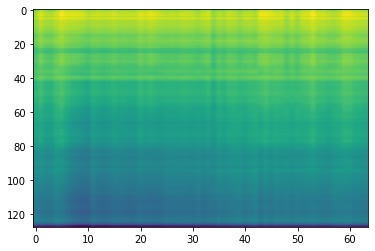

2020-11-08 03:26:48,825 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:12.083516, valid_AUC:0.744837, valid_pAUC:0.571421
100%|██████████| 2407/2407 [00:15<00:00, 157.80it/s]
2020-11-08 03:27:23,061 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:11.955587, valid_AUC:0.749712, valid_pAUC:0.584476
100%|██████████| 2407/2407 [00:17<00:00, 141.45it/s]
2020-11-08 03:27:58,524 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:11.909567, valid_AUC:0.737843, valid_pAUC:0.570820
100%|██████████| 2407/2407 [00:19<00:00, 123.37it/s]
2020-11-08 03:28:36,263 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:11.917291, valid_AUC:0.760855, valid_pAUC:0.583278
100%|██████████| 2407/2407 [00:19<00:00, 122.77it/s]
2020-11-08 03:29:13,297 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:11.899018, valid_AUC:0.744606, valid_pAUC:0.570473
100%|██████████| 2407/2407 [00:18<00:00, 132.48it/s]
2020-11-08 03:29:49,351 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:11.836301, v

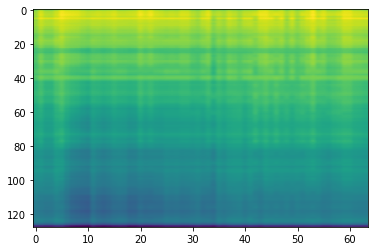

2020-11-08 03:32:50,104 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:11.737374, valid_AUC:0.745527, valid_pAUC:0.595837
100%|██████████| 2407/2407 [00:16<00:00, 141.85it/s]
2020-11-08 03:33:25,410 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:11.592555, valid_AUC:0.727511, valid_pAUC:0.575516
100%|██████████| 2407/2407 [00:15<00:00, 155.56it/s]
2020-11-08 03:33:59,715 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:11.551123, valid_AUC:0.738053, valid_pAUC:0.542653
100%|██████████| 2407/2407 [00:17<00:00, 136.06it/s]
2020-11-08 03:34:36,525 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:11.394829, valid_AUC:0.752994, valid_pAUC:0.569054
100%|██████████| 2407/2407 [00:19<00:00, 123.08it/s]
2020-11-08 03:35:14,252 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:11.414659, valid_AUC:0.752642, valid_pAUC:0.597711
100%|██████████| 2407/2407 [00:19<00:00, 121.60it/s]
2020-11-08 03:35:51,249 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:11.171109, v

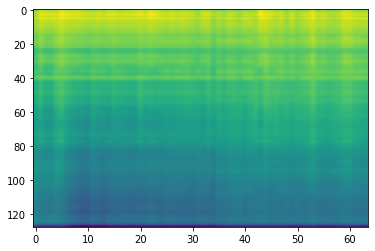

2020-11-08 03:38:51,844 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:11.023922, valid_AUC:0.753289, valid_pAUC:0.594399
100%|██████████| 2407/2407 [00:19<00:00, 125.04it/s]
2020-11-08 03:39:28,472 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:10.921275, valid_AUC:0.767062, valid_pAUC:0.623153
100%|██████████| 2407/2407 [00:17<00:00, 139.75it/s]
2020-11-08 03:40:03,932 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:10.929302, valid_AUC:0.738387, valid_pAUC:0.572560
100%|██████████| 2407/2407 [00:15<00:00, 156.74it/s]
2020-11-08 03:40:38,060 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:10.894280, valid_AUC:0.763432, valid_pAUC:0.604136
100%|██████████| 2407/2407 [00:16<00:00, 141.93it/s]
2020-11-08 03:41:13,867 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:10.875396, valid_AUC:0.784422, valid_pAUC:0.606913
100%|██████████| 2407/2407 [00:19<00:00, 123.68it/s]
2020-11-08 03:41:51,402 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:10.877014, v

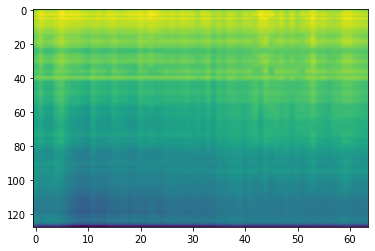

2020-11-08 03:44:52,005 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:10.847739, valid_AUC:0.780668, valid_pAUC:0.624801
100%|██████████| 2407/2407 [00:19<00:00, 123.80it/s]
2020-11-08 03:45:29,160 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:10.798586, valid_AUC:0.771478, valid_pAUC:0.622078
100%|██████████| 2407/2407 [00:19<00:00, 124.48it/s]
2020-11-08 03:46:06,023 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:10.773367, valid_AUC:0.774173, valid_pAUC:0.606506
100%|██████████| 2407/2407 [00:17<00:00, 141.45it/s]
2020-11-08 03:46:41,280 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:10.807813, valid_AUC:0.790329, valid_pAUC:0.606264
100%|██████████| 2407/2407 [00:15<00:00, 156.55it/s]
2020-11-08 03:47:15,851 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:10.742794, valid_AUC:0.768225, valid_pAUC:0.597490
100%|██████████| 2407/2407 [00:17<00:00, 136.49it/s]
2020-11-08 03:47:52,782 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:10.810098, v

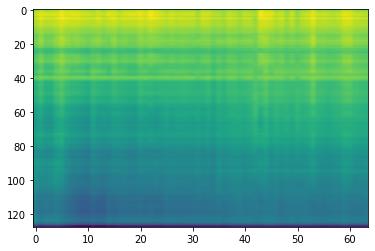

2020-11-08 03:50:54,620 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:10.705850, valid_AUC:0.761020, valid_pAUC:0.619864
100%|██████████| 2407/2407 [00:19<00:00, 124.39it/s]
2020-11-08 03:51:32,566 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:10.647424, valid_AUC:0.766122, valid_pAUC:0.603886
100%|██████████| 2407/2407 [00:19<00:00, 122.04it/s]
2020-11-08 03:52:09,645 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:10.587944, valid_AUC:0.746655, valid_pAUC:0.595189
100%|██████████| 2407/2407 [00:18<00:00, 131.18it/s]
2020-11-08 03:52:45,969 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:10.559297, valid_AUC:0.753000, valid_pAUC:0.603923
100%|██████████| 2407/2407 [00:16<00:00, 147.92it/s]
2020-11-08 03:53:21,002 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:10.497551, valid_AUC:0.727631, valid_pAUC:0.587071
100%|██████████| 2407/2407 [00:15<00:00, 150.88it/s]
2020-11-08 03:53:55,847 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:10.418749, v

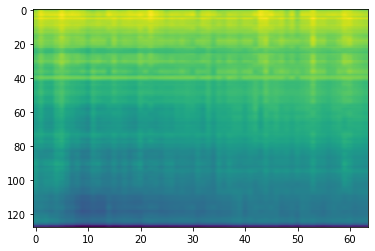

2020-11-08 03:56:57,803 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:10.288071, valid_AUC:0.729557, valid_pAUC:0.580198
100%|██████████| 2407/2407 [00:17<00:00, 138.77it/s]
2020-11-08 03:57:33,981 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:10.231550, valid_AUC:0.751641, valid_pAUC:0.602654
100%|██████████| 2407/2407 [00:25<00:00, 93.20it/s] 
2020-11-08 03:58:17,931 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:10.197008, valid_AUC:0.731598, valid_pAUC:0.577641
100%|██████████| 2407/2407 [00:23<00:00, 103.72it/s]
2020-11-08 03:59:33,471 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:10.132452, valid_AUC:0.741112, valid_pAUC:0.590240
100%|██████████| 2407/2407 [00:27<00:00, 86.63it/s]
2020-11-08 04:00:20,875 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:10.109391, valid_AUC:0.757305, valid_pAUC:0.597177
100%|██████████| 2407/2407 [00:18<00:00, 130.03it/s]
2020-11-08 04:00:56,901 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:10.038510, va

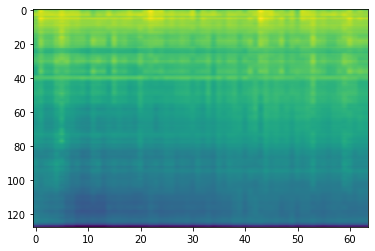

2020-11-08 04:03:58,002 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:9.830111, valid_AUC:0.733322, valid_pAUC:0.585436
100%|██████████| 2407/2407 [00:18<00:00, 126.98it/s]
2020-11-08 04:04:34,282 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:9.862629, valid_AUC:0.752825, valid_pAUC:0.596531
100%|██████████| 2407/2407 [00:18<00:00, 127.67it/s]
2020-11-08 04:05:10,317 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:9.769865, valid_AUC:0.749696, valid_pAUC:0.597569
100%|██████████| 2407/2407 [00:18<00:00, 127.89it/s]
2020-11-08 04:05:46,490 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:9.757167, valid_AUC:0.736863, valid_pAUC:0.591297
100%|██████████| 2407/2407 [00:18<00:00, 128.00it/s]
2020-11-08 04:06:22,866 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:9.721040, valid_AUC:0.734511, valid_pAUC:0.587224
100%|██████████| 2407/2407 [00:18<00:00, 127.86it/s]
2020-11-08 04:06:58,960 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:9.685668, valid_A

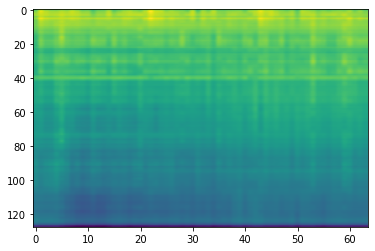

2020-11-08 04:10:00,063 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:9.625953, valid_AUC:0.756063, valid_pAUC:0.600847
100%|██████████| 2407/2407 [00:18<00:00, 126.78it/s]
2020-11-08 04:10:36,257 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:9.734121, valid_AUC:0.761537, valid_pAUC:0.611516
100%|██████████| 2407/2407 [00:18<00:00, 130.12it/s]
2020-11-08 04:11:12,156 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:9.663937, valid_AUC:0.743404, valid_pAUC:0.603527
100%|██████████| 2407/2407 [00:18<00:00, 127.96it/s]
2020-11-08 04:11:48,242 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:9.549749, valid_AUC:0.769177, valid_pAUC:0.608468
100%|██████████| 2407/2407 [00:18<00:00, 128.15it/s]
2020-11-08 04:12:24,576 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:9.502907, valid_AUC:0.782552, valid_pAUC:0.622425
100%|██████████| 2407/2407 [00:18<00:00, 128.60it/s]
2020-11-08 04:13:00,583 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:9.478714, valid_A

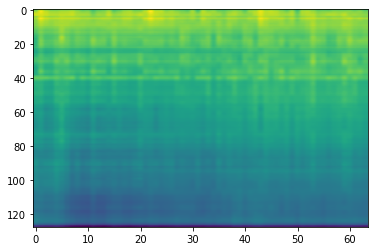

2020-11-08 04:16:01,295 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:9.302424, valid_AUC:0.779684, valid_pAUC:0.617986
2020-11-08 04:16:01,343 - 00_train.py - INFO - 
 success:ToyCar 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AEs/bidirectional_LSTM_AE_window_shift/models/ToyCar_model.pth


elapsed time: 3678.515221357 [sec]


2020-11-08 04:16:02,064 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyConveyor
2020-11-08 04:16:02,065 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-08 04:16:02,067 - 00_train.py - INFO - TRAINING
  1%|          | 1/94 [00:00<00:13,  6.79it/s]

use: cuda:0


100%|██████████| 3452/3452 [00:26<00:00, 130.16it/s]


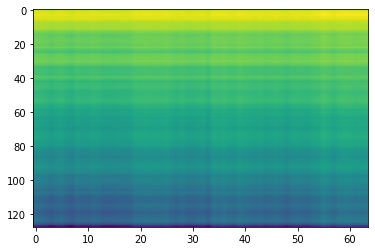

2020-11-08 04:16:43,280 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:77.266416, valid_AUC:0.532293, valid_pAUC:0.507159
100%|██████████| 3452/3452 [00:25<00:00, 135.80it/s]
2020-11-08 04:17:22,965 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:16.803321, valid_AUC:0.541163, valid_pAUC:0.506315
100%|██████████| 3452/3452 [00:24<00:00, 141.40it/s]
2020-11-08 04:18:02,145 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:16.738745, valid_AUC:0.534738, valid_pAUC:0.505723
100%|██████████| 3452/3452 [00:22<00:00, 152.05it/s]
2020-11-08 04:18:40,241 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:16.669335, valid_AUC:0.537048, valid_pAUC:0.506715
100%|██████████| 3452/3452 [00:23<00:00, 149.43it/s]
2020-11-08 04:19:18,708 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:16.598369, valid_AUC:0.530526, valid_pAUC:0.507452
100%|██████████| 3452/3452 [00:24<00:00, 138.26it/s]
2020-11-08 04:19:58,957 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:16.595334, valid_A

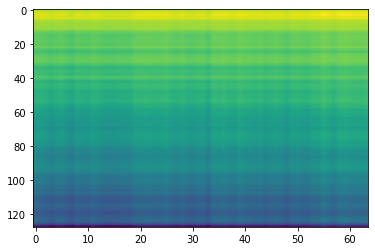

2020-11-08 04:22:38,711 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:16.576577, valid_AUC:0.537061, valid_pAUC:0.506309
100%|██████████| 3452/3452 [00:22<00:00, 152.51it/s]
2020-11-08 04:23:16,671 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:16.590281, valid_AUC:0.542159, valid_pAUC:0.505297
100%|██████████| 3452/3452 [00:22<00:00, 151.47it/s]
2020-11-08 04:23:55,249 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:16.608387, valid_AUC:0.539569, valid_pAUC:0.505532
100%|██████████| 3452/3452 [00:25<00:00, 137.99it/s]
2020-11-08 04:24:35,767 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:16.665364, valid_AUC:0.531885, valid_pAUC:0.506682
100%|██████████| 3452/3452 [00:25<00:00, 135.79it/s]
2020-11-08 04:25:15,814 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:16.574322, valid_AUC:0.539924, valid_pAUC:0.506375
100%|██████████| 3452/3452 [00:25<00:00, 134.10it/s]
2020-11-08 04:25:55,852 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:16.592234, v

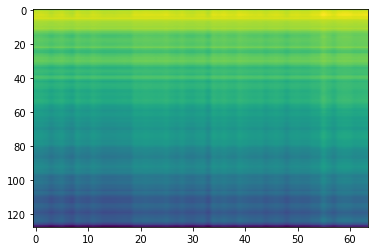

2020-11-08 04:29:10,931 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:16.562466, valid_AUC:0.539959, valid_pAUC:0.506677
100%|██████████| 3452/3452 [00:25<00:00, 134.48it/s]
2020-11-08 04:29:51,381 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:16.427546, valid_AUC:0.544954, valid_pAUC:0.506857
100%|██████████| 3452/3452 [00:25<00:00, 135.25it/s]
2020-11-08 04:30:31,164 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:16.518757, valid_AUC:0.546455, valid_pAUC:0.506748
100%|██████████| 3452/3452 [00:25<00:00, 136.32it/s]
2020-11-08 04:31:10,733 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:16.451962, valid_AUC:0.543783, valid_pAUC:0.506826
100%|██████████| 3452/3452 [00:25<00:00, 136.54it/s]
2020-11-08 04:31:50,373 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:16.483797, valid_AUC:0.549599, valid_pAUC:0.506548
100%|██████████| 3452/3452 [00:23<00:00, 147.87it/s]
2020-11-08 04:32:28,784 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:16.513239, v

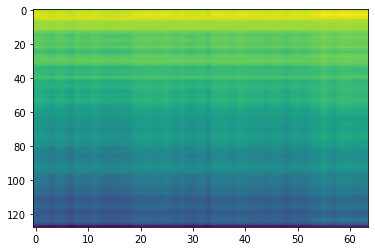

2020-11-08 04:35:46,114 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:16.343700, valid_AUC:0.550870, valid_pAUC:0.506036
100%|██████████| 3452/3452 [00:25<00:00, 136.63it/s]
2020-11-08 04:36:25,919 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:16.548025, valid_AUC:0.545920, valid_pAUC:0.505628
100%|██████████| 3452/3452 [00:23<00:00, 147.02it/s]
2020-11-08 04:37:04,784 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:16.347999, valid_AUC:0.547965, valid_pAUC:0.506548
100%|██████████| 3452/3452 [00:21<00:00, 158.86it/s]
2020-11-08 04:37:42,398 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:16.417727, valid_AUC:0.553228, valid_pAUC:0.506734
100%|██████████| 3452/3452 [00:23<00:00, 143.92it/s]
2020-11-08 04:38:22,206 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:16.434247, valid_AUC:0.542975, valid_pAUC:0.506542
100%|██████████| 3452/3452 [00:25<00:00, 136.49it/s]
2020-11-08 04:39:02,469 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:16.305283, v

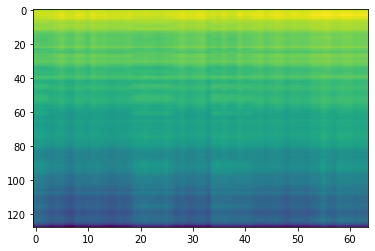

2020-11-08 04:42:18,603 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:15.018458, valid_AUC:0.555922, valid_pAUC:0.516405
100%|██████████| 3452/3452 [00:23<00:00, 148.19it/s]
2020-11-08 04:42:57,760 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:14.732392, valid_AUC:0.562566, valid_pAUC:0.514088
100%|██████████| 3452/3452 [00:24<00:00, 139.00it/s]
2020-11-08 04:43:37,747 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:14.636463, valid_AUC:0.567969, valid_pAUC:0.513924
100%|██████████| 3452/3452 [00:25<00:00, 134.25it/s]
2020-11-08 04:44:17,953 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:14.392007, valid_AUC:0.562110, valid_pAUC:0.511057
100%|██████████| 3452/3452 [00:25<00:00, 136.00it/s]
2020-11-08 04:44:57,764 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:14.502717, valid_AUC:0.563586, valid_pAUC:0.510544
100%|██████████| 3452/3452 [00:25<00:00, 136.17it/s]
2020-11-08 04:45:37,393 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:14.429434, v

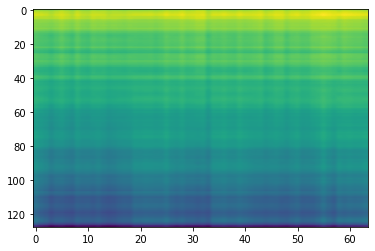

2020-11-08 04:48:54,132 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:14.260931, valid_AUC:0.578542, valid_pAUC:0.513220
100%|██████████| 3452/3452 [00:25<00:00, 137.82it/s]
2020-11-08 04:49:33,682 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:14.301552, valid_AUC:0.582959, valid_pAUC:0.512101
100%|██████████| 3452/3452 [00:25<00:00, 135.25it/s]
2020-11-08 04:50:13,719 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:14.241099, valid_AUC:0.577882, valid_pAUC:0.506982
100%|██████████| 3452/3452 [00:24<00:00, 142.17it/s]
2020-11-08 04:50:52,741 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:14.151263, valid_AUC:0.586128, valid_pAUC:0.512177
100%|██████████| 3452/3452 [00:22<00:00, 154.28it/s]
2020-11-08 04:51:30,755 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:14.275133, valid_AUC:0.583950, valid_pAUC:0.508677
100%|██████████| 3452/3452 [00:23<00:00, 149.97it/s]
2020-11-08 04:52:09,447 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:14.197864, v

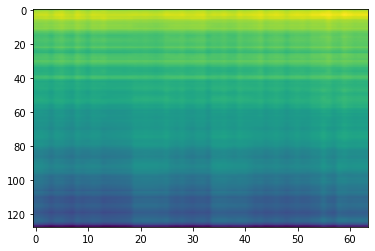

2020-11-08 04:55:28,867 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:14.149794, valid_AUC:0.588423, valid_pAUC:0.511075
100%|██████████| 3452/3452 [00:22<00:00, 154.22it/s]
2020-11-08 04:56:07,066 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:13.964698, valid_AUC:0.589418, valid_pAUC:0.513974
100%|██████████| 3452/3452 [00:23<00:00, 149.05it/s]
2020-11-08 04:56:45,797 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:14.172476, valid_AUC:0.583068, valid_pAUC:0.508658
100%|██████████| 3452/3452 [00:24<00:00, 140.00it/s]
2020-11-08 04:57:25,622 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:14.112048, valid_AUC:0.605451, valid_pAUC:0.512025
100%|██████████| 3452/3452 [00:34<00:00, 99.99it/s] 
2020-11-08 04:58:14,819 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:14.173680, valid_AUC:0.593484, valid_pAUC:0.510648
100%|██████████| 3452/3452 [00:30<00:00, 113.29it/s]
2020-11-08 04:59:28,793 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:13.917954, v

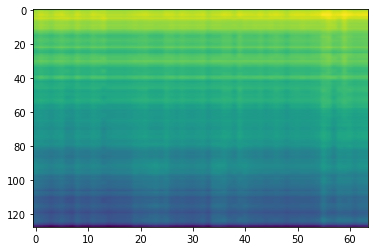

2020-11-08 05:03:07,171 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:13.841625, valid_AUC:0.591518, valid_pAUC:0.513875
100%|██████████| 3452/3452 [00:28<00:00, 121.45it/s]
2020-11-08 05:03:50,925 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:13.681634, valid_AUC:0.587564, valid_pAUC:0.511448
100%|██████████| 3452/3452 [00:28<00:00, 120.70it/s]
2020-11-08 05:04:35,704 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:13.686527, valid_AUC:0.599985, valid_pAUC:0.509835
100%|██████████| 3452/3452 [00:27<00:00, 127.06it/s]
2020-11-08 05:05:18,323 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:13.667394, valid_AUC:0.607679, valid_pAUC:0.509511
100%|██████████| 3452/3452 [00:28<00:00, 119.94it/s]
2020-11-08 05:06:02,622 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:13.631580, valid_AUC:0.607246, valid_pAUC:0.514810
100%|██████████| 3452/3452 [00:27<00:00, 125.11it/s]
2020-11-08 05:06:45,951 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:13.462987, v

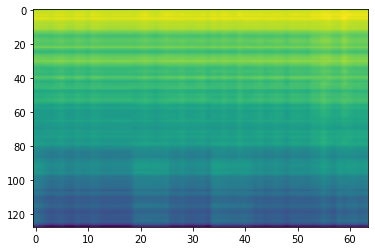

2020-11-08 05:10:23,795 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:13.184314, valid_AUC:0.616487, valid_pAUC:0.513810
100%|██████████| 3452/3452 [00:27<00:00, 125.78it/s]
2020-11-08 05:11:06,745 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:13.044901, valid_AUC:0.614397, valid_pAUC:0.515300
100%|██████████| 3452/3452 [00:29<00:00, 118.22it/s]
2020-11-08 05:11:51,666 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:12.863576, valid_AUC:0.582595, valid_pAUC:0.522806
100%|██████████| 3452/3452 [00:27<00:00, 125.87it/s]
2020-11-08 05:12:34,635 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:12.674329, valid_AUC:0.614562, valid_pAUC:0.525924
100%|██████████| 3452/3452 [00:28<00:00, 122.58it/s]
2020-11-08 05:13:18,083 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:12.577911, valid_AUC:0.617779, valid_pAUC:0.529316
100%|██████████| 3452/3452 [00:27<00:00, 123.83it/s]
2020-11-08 05:14:01,774 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:12.457552, v

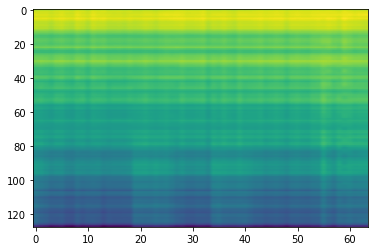

2020-11-08 05:17:40,376 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:12.356930, valid_AUC:0.641581, valid_pAUC:0.537169
100%|██████████| 3452/3452 [00:27<00:00, 126.30it/s]
2020-11-08 05:18:23,300 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:12.104936, valid_AUC:0.648418, valid_pAUC:0.535657
100%|██████████| 3452/3452 [00:28<00:00, 119.70it/s]
2020-11-08 05:19:07,684 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:12.060703, valid_AUC:0.652025, valid_pAUC:0.536317
100%|██████████| 3452/3452 [00:27<00:00, 123.64it/s]
2020-11-08 05:19:51,281 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:12.144521, valid_AUC:0.644981, valid_pAUC:0.539580
100%|██████████| 3452/3452 [00:27<00:00, 124.12it/s]
2020-11-08 05:20:34,522 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:12.092709, valid_AUC:0.645042, valid_pAUC:0.535746
100%|██████████| 3452/3452 [00:28<00:00, 119.39it/s]
2020-11-08 05:21:19,000 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:12.101906, v

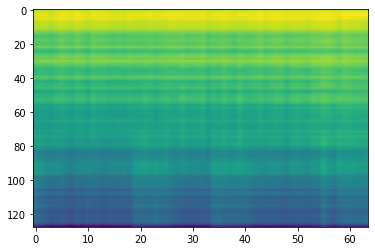

2020-11-08 05:24:57,164 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:11.862554, valid_AUC:0.652331, valid_pAUC:0.537638
2020-11-08 05:24:57,218 - 00_train.py - INFO - 
 success:ToyConveyor 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AEs/bidirectional_LSTM_AE_window_shift/models/ToyConveyor_model.pth


elapsed time: 4135.154903412 [sec]


2020-11-08 05:24:57,827 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2020-11-08 05:24:57,828 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-08 05:24:57,830 - 00_train.py - INFO - TRAINING
  1%|          | 1/91 [00:00<00:13,  6.77it/s]

use: cuda:0


100%|██████████| 855/855 [00:05<00:00, 143.75it/s]


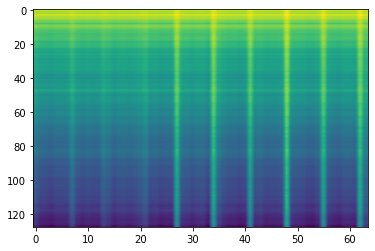

2020-11-08 05:25:19,550 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:143.537298, valid_AUC:0.486242, valid_pAUC:0.493869
100%|██████████| 855/855 [00:07<00:00, 119.53it/s]
2020-11-08 05:25:41,673 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:19.880771, valid_AUC:0.490187, valid_pAUC:0.491006
100%|██████████| 855/855 [00:08<00:00, 105.31it/s]
2020-11-08 05:26:04,722 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:19.433885, valid_AUC:0.489368, valid_pAUC:0.490573
100%|██████████| 855/855 [00:06<00:00, 131.72it/s]
2020-11-08 05:26:26,202 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:19.168812, valid_AUC:0.486835, valid_pAUC:0.489821
100%|██████████| 855/855 [00:05<00:00, 159.03it/s]
2020-11-08 05:26:46,965 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:19.065217, valid_AUC:0.488445, valid_pAUC:0.488201
100%|██████████| 855/855 [00:04<00:00, 180.26it/s]
2020-11-08 05:27:02,734 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:18.181705, valid_AUC:0.4850

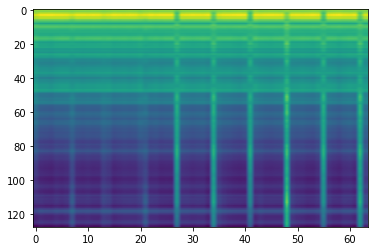

2020-11-08 05:28:06,219 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:15.653140, valid_AUC:0.488940, valid_pAUC:0.490486
100%|██████████| 855/855 [00:04<00:00, 181.64it/s]
2020-11-08 05:28:21,994 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:15.584662, valid_AUC:0.483148, valid_pAUC:0.489705
100%|██████████| 855/855 [00:04<00:00, 181.95it/s]
2020-11-08 05:28:37,861 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:15.447788, valid_AUC:0.485758, valid_pAUC:0.490544
100%|██████████| 855/855 [00:04<00:00, 181.88it/s]
2020-11-08 05:28:53,667 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:15.329729, valid_AUC:0.483665, valid_pAUC:0.495228
100%|██████████| 855/855 [00:04<00:00, 181.40it/s]
2020-11-08 05:29:09,491 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:15.169434, valid_AUC:0.482308, valid_pAUC:0.493811
100%|██████████| 855/855 [00:04<00:00, 181.77it/s]
2020-11-08 05:29:25,253 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:15.282899, valid_AUC:0

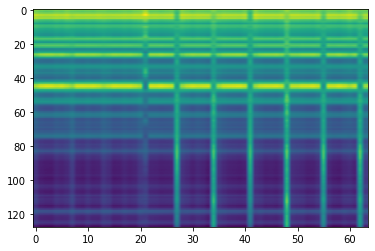

2020-11-08 05:30:44,695 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:13.926235, valid_AUC:0.480593, valid_pAUC:0.493436
100%|██████████| 855/855 [00:04<00:00, 182.01it/s]
2020-11-08 05:31:00,449 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:13.875256, valid_AUC:0.479538, valid_pAUC:0.497311
100%|██████████| 855/855 [00:04<00:00, 181.08it/s]
2020-11-08 05:31:16,257 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:13.646627, valid_AUC:0.479027, valid_pAUC:0.498757
100%|██████████| 855/855 [00:04<00:00, 181.39it/s]
2020-11-08 05:31:31,971 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:13.328330, valid_AUC:0.481819, valid_pAUC:0.500405
100%|██████████| 855/855 [00:04<00:00, 181.48it/s]
2020-11-08 05:31:47,808 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:13.142885, valid_AUC:0.483132, valid_pAUC:0.501909
100%|██████████| 855/855 [00:04<00:00, 182.94it/s]
2020-11-08 05:32:03,610 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:12.894553, valid_AUC:0

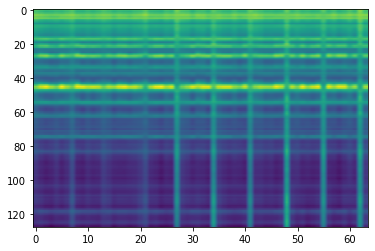

2020-11-08 05:33:22,369 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:11.847841, valid_AUC:0.490066, valid_pAUC:0.505379
100%|██████████| 855/855 [00:04<00:00, 182.42it/s]
2020-11-08 05:33:38,189 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:12.051413, valid_AUC:0.496412, valid_pAUC:0.503499
100%|██████████| 855/855 [00:04<00:00, 180.94it/s]
2020-11-08 05:33:54,015 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:11.714262, valid_AUC:0.497055, valid_pAUC:0.502487
100%|██████████| 855/855 [00:04<00:00, 181.93it/s]
2020-11-08 05:34:09,863 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:11.613307, valid_AUC:0.499390, valid_pAUC:0.502603
100%|██████████| 855/855 [00:04<00:00, 182.47it/s]
2020-11-08 05:34:25,590 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:11.517903, valid_AUC:0.498896, valid_pAUC:0.504887
100%|██████████| 855/855 [00:04<00:00, 181.27it/s]
2020-11-08 05:34:41,356 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:11.504833, valid_AUC:0

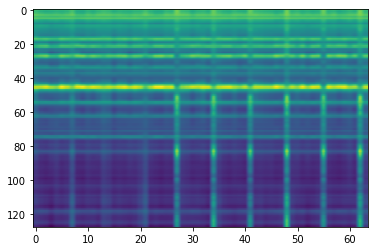

2020-11-08 05:36:00,394 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:11.165646, valid_AUC:0.510808, valid_pAUC:0.501330
100%|██████████| 855/855 [00:04<00:00, 181.78it/s]
2020-11-08 05:36:16,194 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:11.156758, valid_AUC:0.512066, valid_pAUC:0.501938
100%|██████████| 855/855 [00:04<00:00, 181.26it/s]
2020-11-08 05:36:31,992 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:11.179484, valid_AUC:0.515703, valid_pAUC:0.501475
100%|██████████| 855/855 [00:04<00:00, 181.54it/s]
2020-11-08 05:36:47,808 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:11.259117, valid_AUC:0.513808, valid_pAUC:0.501533
100%|██████████| 855/855 [00:04<00:00, 182.24it/s]
2020-11-08 05:37:03,513 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:11.052780, valid_AUC:0.517401, valid_pAUC:0.500925
100%|██████████| 855/855 [00:04<00:00, 182.00it/s]
2020-11-08 05:37:19,341 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:11.008249, valid_AUC:0

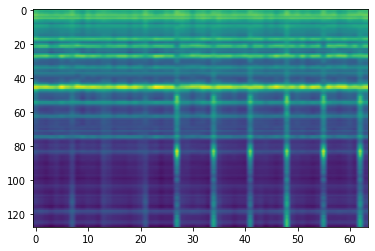

2020-11-08 05:38:38,610 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:10.699982, valid_AUC:0.524330, valid_pAUC:0.499393
100%|██████████| 855/855 [00:04<00:00, 181.63it/s]
2020-11-08 05:38:54,332 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:10.721653, valid_AUC:0.522973, valid_pAUC:0.498236
100%|██████████| 855/855 [00:04<00:00, 181.74it/s]
2020-11-08 05:39:10,088 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:10.661581, valid_AUC:0.528264, valid_pAUC:0.498670
100%|██████████| 855/855 [00:04<00:00, 182.23it/s]
2020-11-08 05:39:25,776 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:10.637432, valid_AUC:0.524341, valid_pAUC:0.499393
100%|██████████| 855/855 [00:04<00:00, 182.09it/s]
2020-11-08 05:39:41,594 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:10.774202, valid_AUC:0.528341, valid_pAUC:0.498005
100%|██████████| 855/855 [00:04<00:00, 181.29it/s]
2020-11-08 05:39:57,591 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:10.630828, valid_AUC:0

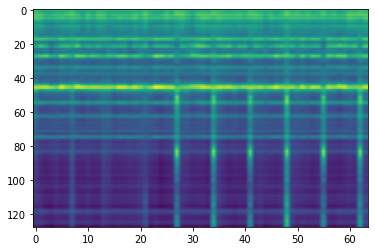

2020-11-08 05:41:16,474 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:10.398538, valid_AUC:0.530830, valid_pAUC:0.499711
100%|██████████| 855/855 [00:04<00:00, 181.35it/s]
2020-11-08 05:41:32,308 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:10.426721, valid_AUC:0.529797, valid_pAUC:0.500376
100%|██████████| 855/855 [00:04<00:00, 182.19it/s]
2020-11-08 05:41:48,075 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:10.520380, valid_AUC:0.534973, valid_pAUC:0.499104
100%|██████████| 855/855 [00:04<00:00, 182.32it/s]
2020-11-08 05:42:04,070 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:10.424162, valid_AUC:0.537522, valid_pAUC:0.499508
100%|██████████| 855/855 [00:04<00:00, 180.87it/s]
2020-11-08 05:42:19,841 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:10.410558, valid_AUC:0.531192, valid_pAUC:0.500636
100%|██████████| 855/855 [00:04<00:00, 181.85it/s]
2020-11-08 05:42:35,619 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:10.469518, valid_AUC:0

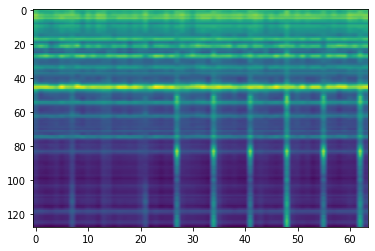

2020-11-08 05:43:54,480 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:10.288059, valid_AUC:0.538060, valid_pAUC:0.498120
100%|██████████| 855/855 [00:04<00:00, 180.49it/s]
2020-11-08 05:44:10,356 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:10.247935, valid_AUC:0.546082, valid_pAUC:0.499132
100%|██████████| 855/855 [00:04<00:00, 182.45it/s]
2020-11-08 05:44:26,162 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:10.414983, valid_AUC:0.534236, valid_pAUC:0.501099
100%|██████████| 855/855 [00:04<00:00, 183.04it/s]
2020-11-08 05:44:42,010 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:10.314515, valid_AUC:0.538780, valid_pAUC:0.498930
100%|██████████| 855/855 [00:04<00:00, 181.59it/s]
2020-11-08 05:44:57,774 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:10.222509, valid_AUC:0.542637, valid_pAUC:0.500694
100%|██████████| 855/855 [00:04<00:00, 181.89it/s]
2020-11-08 05:45:13,541 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:10.276048, valid_AUC:0

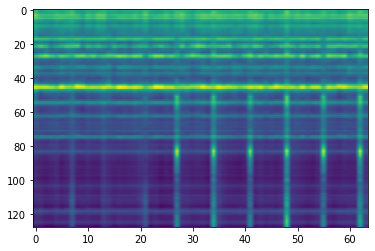

2020-11-08 05:46:32,804 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:10.036722, valid_AUC:0.541003, valid_pAUC:0.500578
100%|██████████| 855/855 [00:04<00:00, 181.53it/s]
2020-11-08 05:46:48,597 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:10.027057, valid_AUC:0.547319, valid_pAUC:0.499248
100%|██████████| 855/855 [00:04<00:00, 182.73it/s]
2020-11-08 05:47:04,347 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:10.017875, valid_AUC:0.550069, valid_pAUC:0.498728
100%|██████████| 855/855 [00:04<00:00, 182.45it/s]
2020-11-08 05:47:20,217 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:9.970180, valid_AUC:0.554934, valid_pAUC:0.498583
100%|██████████| 855/855 [00:04<00:00, 182.08it/s]
2020-11-08 05:47:35,962 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:9.929885, valid_AUC:0.548110, valid_pAUC:0.499104
100%|██████████| 855/855 [00:04<00:00, 173.94it/s]
2020-11-08 05:47:52,051 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:10.043618, valid_AUC:0.5

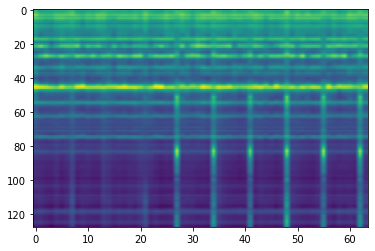

2020-11-08 05:49:11,204 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:9.929140, valid_AUC:0.565330, valid_pAUC:0.497918
100%|██████████| 855/855 [00:04<00:00, 182.40it/s]
2020-11-08 05:49:27,029 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:9.889101, valid_AUC:0.545121, valid_pAUC:0.498294
100%|██████████| 855/855 [00:04<00:00, 181.96it/s]
2020-11-08 05:49:42,807 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:9.787626, valid_AUC:0.553753, valid_pAUC:0.499364
100%|██████████| 855/855 [00:04<00:00, 181.14it/s]
2020-11-08 05:49:58,856 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:9.842443, valid_AUC:0.548929, valid_pAUC:0.498814
100%|██████████| 855/855 [00:04<00:00, 182.73it/s]
2020-11-08 05:50:14,684 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:9.726573, valid_AUC:0.550198, valid_pAUC:0.498930
100%|██████████| 855/855 [00:04<00:00, 181.78it/s]
2020-11-08 05:50:30,483 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:9.778672, valid_AUC:0.54867

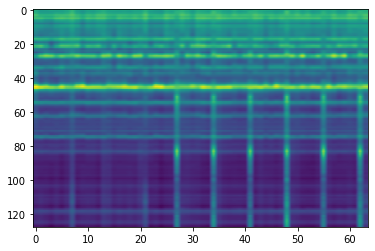

2020-11-08 05:51:49,770 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:9.772305, valid_AUC:0.544816, valid_pAUC:0.499971
2020-11-08 05:51:49,821 - 00_train.py - INFO - 
 success:valve 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AEs/bidirectional_LSTM_AE_window_shift/models/valve_model.pth


elapsed time: 1611.994802237 [sec]


In [11]:
for machine_type in machine_types:
    history = run(machine_type)
    with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
        pickle.dump(history , file)

history = run('ToyCar')
with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
    pickle.dump(history , file)